In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dropout

import tensorflow
tensorflow.random.set_seed(2022)

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, RandomizedSearchCV

# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout = go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('PGE_SA.csv').fillna('ffill')
df = df.sort_index(ascending=False)
df.index = range(len(df))
df['Data'] = pd.to_datetime(df['Data'])
df = df.rename(columns={'Maks.':'Maks'})
df = df.rename(columns={'Min.':'Min'})
df.head()

,Data,Otwarcie,Zamknięcie,Maks,Min,Obrót (mln. zł),Zmiana (%)
0,2010-10-01,17.16,16.98,17.16,16.85,30.36,0.00
1,2010-10-04,16.98,17.05,17.07,16.73,47.29,0.43
2,2010-10-05,16.99,16.82,17.00,16.82,36.29,-1.38
3,2010-10-06,16.87,16.50,16.93,16.50,48.64,-1.88
4,2010-10-07,15.72,15.84,16.05,15.67,271.00,-4.00


### Shift label column

In [3]:
for i in range(1, 31):
    name = 'Otwarcie_' + str(i) + 'day'
    df[name] = df['Otwarcie'].shift(-i)
    name = 'Zamknięcie_' + str(i) + 'day'
    df[name] = df['Zamknięcie'].shift(i)

### Drop invalid samples

In [4]:
df = df.iloc[31:]
df = df[:-30]
df.index = range(len(df))

### Split data

In [5]:
test_size = 0.2

test_split_idx = int(df.shape[0] * (1-test_size))

train_df = df.loc[:test_split_idx].copy()
test_df = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Data, y=train_df.Otwarcie, name='Training'))
fig.add_trace(go.Scatter(x=test_df.Data, y=test_df.Otwarcie, name='Test'))
fig.show()

### Drop unnecessary columns

In [6]:
drop_cols = ['Data', 'Obrót (mln. zł)', 'Zmiana (%)', 'Otwarcie', 'Min', 'Maks']

train_df = train_df.drop(drop_cols, 1)
test_df = test_df.drop(drop_cols, 1)

## 1 day ahead

7 days of history data

In [7]:
x_label = ['Zamknięcie']
for i in range(1, 7):
    label = 'Zamknięcie_'+ str(i) + 'day'
    x_label.append(label)
X_train = train_df[x_label]
y_train = train_df['Otwarcie_1day']
X_test = test_df[x_label]
y_test = test_df['Otwarcie_1day']
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = y_train.values
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [8]:
from numpy.random import seed
seed(2022)
model = Sequential()


model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))

model.add(Dropout(0.20))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.25))


model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = model.fit(X_train, y_train, epochs = 45, batch_size = 32, validation_split=0.3)

Epoch 1/45
44/44 [==============================] - 6s 52ms/step - loss: 211.8847 - val_loss: 2.2682
Epoch 2/45
44/44 [==============================] - 1s 12ms/step - loss: 24.6140 - val_loss: 5.4676
Epoch 3/45
44/44 [==============================] - 0s 11ms/step - loss: 10.9370 - val_loss: 12.1043
Epoch 4/45
44/44 [==============================] - 1s 12ms/step - loss: 6.7695 - val_loss: 17.2517
Epoch 5/45
44/44 [==============================] - 1s 11ms/step - loss: 5.9213 - val_loss: 20.1052
Epoch 6/45
44/44 [==============================] - 1s 12ms/step - loss: 5.6993 - val_loss: 20.4284
Epoch 7/45
44/44 [==============================] - 1s 11ms/step - loss: 5.6205 - val_loss: 21.0986
Epoch 8/45
44/44 [==============================] - 0s 11ms/step - loss: 5.8401 - val_loss: 21.1656
Epoch 9/45
44/44 [==============================] - 1s 15ms/step - loss: 5.7956 - val_loss: 21.2357
Epoch 10/45
44/44 [==============================] - 1s 12ms/step - loss: 5.9286 - val_loss: 21.13

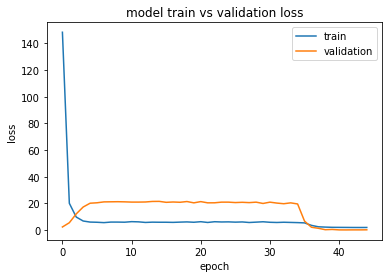

In [9]:
plt.plot(history.history[ 'loss' ]) 
plt.plot(history.history[ 'val_loss' ]) 
plt.title( 'model train vs validation loss' ) 
plt.ylabel( 'loss' ) 
plt.xlabel( 'epoch' ) 
plt.legend([ 'train' , 'validation' ], loc= 'upper right' ) 
plt.show()

In [10]:
y_pred = model.predict(X_test)

In [11]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Otwarcie'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Data, y=df.Otwarcie,
                        name='Truth',
                        marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Data,
                        y=predicted_prices.Otwarcie,
                        name='Prediction',
                        marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Data,
                        y=y_test,
                        name='Truth',
                        marker_color='LightSkyBlue',
                        showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Data,
                        y=predicted_prices.Otwarcie,
                        name='Prediction',
                        marker_color='MediumPurple',
                        showlegend=False), row=2, col=1)

fig.show()

In [12]:
print(f'MSE = {mean_squared_error(y_test, y_pred)}')
print(f'MAE = {mean_absolute_error(y_test, y_pred)}')
print(f'RMSE = {math.sqrt(mean_squared_error(y_test, y_pred))}')

MSE = 0.1696369441621257
MAE = 0.3808617964023497
RMSE = 0.41187005737504845


30 days of history data

In [13]:
x_label = ['Zamknięcie']
for i in range(1, 30):
    label = 'Zamknięcie_'+ str(i) + 'day'
    x_label.append(label)
X_train = train_df[x_label]
y_train = train_df['Otwarcie_1day']
X_test = test_df[x_label]
y_test = test_df['Otwarcie_1day']
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = y_train.values
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [14]:
seed(2022)
model = Sequential()


model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))

model.add(Dropout(0.20))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.25))


model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = model.fit(X_train, y_train, epochs = 403, batch_size = 250, validation_split=0.3)

Epoch 1/403
6/6 [==============================] - 6s 393ms/step - loss: 250.1575 - val_loss: 120.7360
Epoch 2/403
6/6 [==============================] - 1s 165ms/step - loss: 216.2805 - val_loss: 74.2312
Epoch 3/403
6/6 [==============================] - 1s 174ms/step - loss: 151.8968 - val_loss: 42.0166
Epoch 4/403
6/6 [==============================] - 1s 179ms/step - loss: 112.8359 - val_loss: 25.5692
Epoch 5/403
6/6 [==============================] - 1s 175ms/step - loss: 85.2992 - val_loss: 15.1845
Epoch 6/403
6/6 [==============================] - 1s 176ms/step - loss: 68.6496 - val_loss: 9.6734
Epoch 7/403
6/6 [==============================] - 1s 175ms/step - loss: 56.0733 - val_loss: 6.6175
Epoch 8/403
6/6 [==============================] - 1s 174ms/step - loss: 48.2180 - val_loss: 4.7872
Epoch 9/403
6/6 [==============================] - 1s 175ms/step - loss: 42.4999 - val_loss: 3.6013
Epoch 10/403
6/6 [==============================] - 1s 201ms/step - loss: 37.7314 - val_lo

6/6 [==============================] - 1s 198ms/step - loss: 5.9234 - val_loss: 21.0444
Epoch 83/403
6/6 [==============================] - 1s 185ms/step - loss: 5.9461 - val_loss: 21.0687
Epoch 84/403
6/6 [==============================] - 1s 184ms/step - loss: 6.0378 - val_loss: 21.0713
Epoch 85/403
6/6 [==============================] - 1s 216ms/step - loss: 5.8919 - val_loss: 21.0637
Epoch 86/403
6/6 [==============================] - 1s 208ms/step - loss: 6.0696 - val_loss: 21.0957
Epoch 87/403
6/6 [==============================] - 1s 205ms/step - loss: 5.5878 - val_loss: 21.1075
Epoch 88/403
6/6 [==============================] - 1s 183ms/step - loss: 6.1552 - val_loss: 21.1090
Epoch 89/403
6/6 [==============================] - 1s 198ms/step - loss: 5.9979 - val_loss: 21.1106
Epoch 90/403
6/6 [==============================] - 1s 179ms/step - loss: 6.0780 - val_loss: 21.0871
Epoch 91/403
6/6 [==============================] - 1s 180ms/step - loss: 6.0436 - val_loss: 21.0407
Epo

6/6 [==============================] - 1s 175ms/step - loss: 5.8562 - val_loss: 20.8893
Epoch 163/403
6/6 [==============================] - 1s 172ms/step - loss: 5.7946 - val_loss: 20.9468
Epoch 164/403
6/6 [==============================] - 1s 203ms/step - loss: 5.8067 - val_loss: 20.9508
Epoch 165/403
6/6 [==============================] - 1s 176ms/step - loss: 5.2981 - val_loss: 20.9906
Epoch 166/403
6/6 [==============================] - 1s 172ms/step - loss: 6.0904 - val_loss: 21.0720
Epoch 167/403
6/6 [==============================] - 1s 180ms/step - loss: 5.5651 - val_loss: 21.1494
Epoch 168/403
6/6 [==============================] - 1s 181ms/step - loss: 5.9720 - val_loss: 21.2111
Epoch 169/403
6/6 [==============================] - 1s 187ms/step - loss: 5.9723 - val_loss: 21.2481
Epoch 170/403
6/6 [==============================] - 1s 189ms/step - loss: 5.8336 - val_loss: 21.2332
Epoch 171/403
6/6 [==============================] - 1s 193ms/step - loss: 5.6286 - val_loss: 21

6/6 [==============================] - 1s 175ms/step - loss: 6.1918 - val_loss: 21.0984
Epoch 243/403
6/6 [==============================] - 1s 176ms/step - loss: 5.9422 - val_loss: 21.1081
Epoch 244/403
6/6 [==============================] - 1s 173ms/step - loss: 6.1320 - val_loss: 21.0735
Epoch 245/403
6/6 [==============================] - 1s 175ms/step - loss: 5.9923 - val_loss: 21.1237
Epoch 246/403
6/6 [==============================] - 1s 173ms/step - loss: 5.9991 - val_loss: 21.1071
Epoch 247/403
6/6 [==============================] - 1s 174ms/step - loss: 5.7868 - val_loss: 21.0697
Epoch 248/403
6/6 [==============================] - 1s 202ms/step - loss: 5.8408 - val_loss: 21.0363
Epoch 249/403
6/6 [==============================] - 1s 173ms/step - loss: 6.0235 - val_loss: 20.9725
Epoch 250/403
6/6 [==============================] - 1s 173ms/step - loss: 5.6773 - val_loss: 20.8570
Epoch 251/403
6/6 [==============================] - 1s 173ms/step - loss: 5.6338 - val_loss: 20

6/6 [==============================] - 1s 178ms/step - loss: 5.5271 - val_loss: 21.1716
Epoch 323/403
6/6 [==============================] - 1s 172ms/step - loss: 5.8988 - val_loss: 21.1815
Epoch 324/403
6/6 [==============================] - 1s 174ms/step - loss: 5.7042 - val_loss: 21.2124
Epoch 325/403
6/6 [==============================] - 1s 173ms/step - loss: 5.9539 - val_loss: 21.2502
Epoch 326/403
6/6 [==============================] - 1s 174ms/step - loss: 5.8200 - val_loss: 21.2510
Epoch 327/403
6/6 [==============================] - 1s 181ms/step - loss: 5.9780 - val_loss: 21.2164
Epoch 328/403
6/6 [==============================] - 1s 185ms/step - loss: 5.3580 - val_loss: 21.1337
Epoch 329/403
6/6 [==============================] - 1s 175ms/step - loss: 5.8534 - val_loss: 21.0681
Epoch 330/403
6/6 [==============================] - 1s 179ms/step - loss: 5.4141 - val_loss: 21.0968
Epoch 331/403
6/6 [==============================] - 1s 177ms/step - loss: 5.5414 - val_loss: 21

6/6 [==============================] - 1s 170ms/step - loss: 2.5881 - val_loss: 0.1943
Epoch 403/403
6/6 [==============================] - 1s 174ms/step - loss: 2.3838 - val_loss: 0.1489


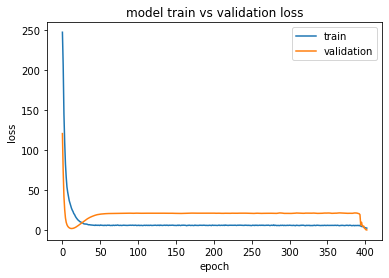

In [15]:
plt.plot(history.history[ 'loss' ]) 
plt.plot(history.history[ 'val_loss' ]) 
plt.title( 'model train vs validation loss' ) 
plt.ylabel( 'loss' ) 
plt.xlabel( 'epoch' ) 
plt.legend([ 'train' , 'validation' ], loc= 'upper right' ) 
plt.show()

In [16]:
y_pred = model.predict(X_test)

In [17]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Otwarcie'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Data, y=df.Otwarcie,
                        name='Truth',
                        marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Data,
                        y=predicted_prices.Otwarcie,
                        name='Prediction',
                        marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Data,
                        y=y_test,
                        name='Truth',
                        marker_color='LightSkyBlue',
                        showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Data,
                        y=predicted_prices.Otwarcie,
                        name='Prediction',
                        marker_color='MediumPurple',
                        showlegend=False), row=2, col=1)

fig.show()

In [18]:
print(f'MSE = {mean_squared_error(y_test, y_pred)}')
print(f'MAE = {mean_absolute_error(y_test, y_pred)}')
print(f'RMSE = {math.sqrt(mean_squared_error(y_test, y_pred))}')

MSE = 23.032263242155334
MAE = 3.313428220889433
RMSE = 4.799194020057465


## 7 days ahead

7 days of history data

In [19]:
x_label = ['Zamknięcie']
for i in range(1, 7):
    label = 'Zamknięcie_'+ str(i) + 'day'
    x_label.append(label)

y_label = []
for i in range(1, 8):
    label = 'Otwarcie_'+ str(i) + 'day'
    y_label.append(label)
X_train = train_df[x_label]
y_train = train_df[y_label].values
X_test = test_df[x_label]
y_test = test_df[y_label].values
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], 1))

In [20]:
from numpy.random import seed
seed(2022)
model = Sequential()


model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))

model.add(Dropout(0.20))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.25))


model.add(Dense(y_train.shape[1]))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = model.fit(X_train, y_train, epochs = 45, batch_size = 32, validation_split=0.3)

Epoch 1/45
44/44 [==============================] - 6s 47ms/step - loss: 232.7063 - val_loss: 44.8114
Epoch 2/45
44/44 [==============================] - 1s 15ms/step - loss: 110.9014 - val_loss: 17.0562
Epoch 3/45
44/44 [==============================] - 1s 16ms/step - loss: 66.3497 - val_loss: 5.5846
Epoch 4/45
44/44 [==============================] - 1s 17ms/step - loss: 39.1021 - val_loss: 2.3500
Epoch 5/45
44/44 [==============================] - 1s 17ms/step - loss: 23.7617 - val_loss: 3.5515
Epoch 6/45
44/44 [==============================] - 1s 16ms/step - loss: 15.3711 - val_loss: 6.6426
Epoch 7/45
44/44 [==============================] - 1s 17ms/step - loss: 10.6232 - val_loss: 10.3413
Epoch 8/45
44/44 [==============================] - 1s 17ms/step - loss: 8.0110 - val_loss: 13.6218
Epoch 9/45
44/44 [==============================] - 1s 16ms/step - loss: 7.0068 - val_loss: 16.2091
Epoch 10/45
44/44 [==============================] - 1s 20ms/step - loss: 6.9359 - val_loss: 18

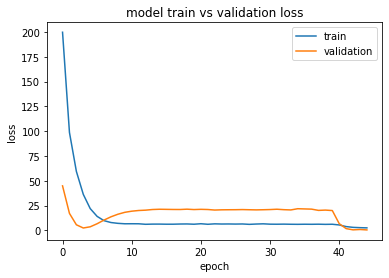

In [21]:
plt.plot(history.history[ 'loss' ]) 
plt.plot(history.history[ 'val_loss' ]) 
plt.title( 'model train vs validation loss' ) 
plt.ylabel( 'loss' ) 
plt.xlabel( 'epoch' ) 
plt.legend([ 'train' , 'validation' ], loc= 'upper right' ) 
plt.show()

In [22]:
y_pred = model.predict(X_test)

In [23]:
y_test = test_df[y_label].values

In [24]:
print(f'MSE = {mean_squared_error(y_test, y_pred)}')
print(f'MAE = {mean_absolute_error(y_test, y_pred)}')
print(f'RMSE = {math.sqrt(mean_squared_error(y_test, y_pred))}')

MSE = 0.3719805625703437
MAE = 0.49363623218115504
RMSE = 0.609902092610235


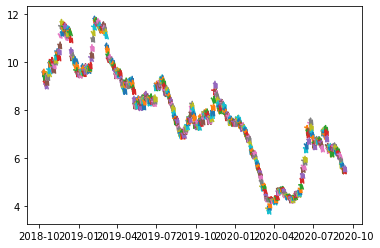

In [25]:
data = df.loc[test_split_idx+1:].Data
for i in range(len(y_pred)-7):
    x = data[i:i+7].tolist()
    y = y_pred[i]
    plt.plot(x, y)

30 days of history data

In [26]:
x_label = ['Zamknięcie']
for i in range(1, 30):
    label = 'Zamknięcie_'+ str(i) + 'day'
    x_label.append(label)

y_label = []
for i in range(1, 8):
    label = 'Otwarcie_'+ str(i) + 'day'
    y_label.append(label)
X_train = train_df[x_label]
y_train = train_df[y_label].values
X_test = test_df[x_label]
y_test = test_df[y_label].values
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], 1))

In [27]:
from numpy.random import seed
seed(2022)
model = Sequential()


model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))

model.add(Dropout(0.20))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.25))


model.add(Dense(y_train.shape[1]))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = model.fit(X_train, y_train, epochs = 1000, batch_size = 32, validation_split=0.3)

Epoch 1/1000
44/44 [==============================] - 8s 79ms/step - loss: 220.4974 - val_loss: 48.0254
Epoch 2/1000
44/44 [==============================] - 2s 50ms/step - loss: 117.1418 - val_loss: 20.5137
Epoch 3/1000
44/44 [==============================] - 2s 50ms/step - loss: 73.2024 - val_loss: 7.7354
Epoch 4/1000
44/44 [==============================] - 2s 51ms/step - loss: 45.0042 - val_loss: 2.9413
Epoch 5/1000
44/44 [==============================] - 2s 53ms/step - loss: 28.3995 - val_loss: 2.8109
Epoch 6/1000
44/44 [==============================] - 2s 50ms/step - loss: 18.4633 - val_loss: 5.1126
Epoch 7/1000
44/44 [==============================] - 2s 50ms/step - loss: 12.4869 - val_loss: 8.7259
Epoch 8/1000
44/44 [==============================] - 2s 56ms/step - loss: 8.7941 - val_loss: 12.2119
Epoch 9/1000
44/44 [==============================] - 2s 50ms/step - loss: 7.4172 - val_loss: 15.0982
Epoch 10/1000
44/44 [==============================] - 2s 50ms/step - loss: 7.

44/44 [==============================] - 2s 49ms/step - loss: 5.4550 - val_loss: 21.5856
Epoch 81/1000
44/44 [==============================] - 2s 49ms/step - loss: 5.7477 - val_loss: 20.9372
Epoch 82/1000
44/44 [==============================] - 2s 49ms/step - loss: 5.6609 - val_loss: 20.7856
Epoch 83/1000
44/44 [==============================] - 2s 49ms/step - loss: 6.3342 - val_loss: 21.6006
Epoch 84/1000
44/44 [==============================] - 2s 49ms/step - loss: 5.9872 - val_loss: 20.7585
Epoch 85/1000
44/44 [==============================] - 2s 49ms/step - loss: 6.1287 - val_loss: 21.8007
Epoch 86/1000
44/44 [==============================] - 3s 65ms/step - loss: 6.2356 - val_loss: 20.1512
Epoch 87/1000
44/44 [==============================] - 3s 61ms/step - loss: 5.8929 - val_loss: 20.6917
Epoch 88/1000
44/44 [==============================] - 2s 55ms/step - loss: 6.1321 - val_loss: 21.0795
Epoch 89/1000
44/44 [==============================] - 3s 58ms/step - loss: 5.6901 - va

44/44 [==============================] - 2s 50ms/step - loss: 5.6959 - val_loss: 19.9504
Epoch 160/1000
44/44 [==============================] - 2s 52ms/step - loss: 5.1787 - val_loss: 20.9033
Epoch 161/1000
44/44 [==============================] - 2s 49ms/step - loss: 5.4024 - val_loss: 20.0158
Epoch 162/1000
44/44 [==============================] - 2s 49ms/step - loss: 5.3917 - val_loss: 21.9021
Epoch 163/1000
44/44 [==============================] - 2s 50ms/step - loss: 5.6801 - val_loss: 21.6113
Epoch 164/1000
44/44 [==============================] - 2s 49ms/step - loss: 5.5838 - val_loss: 21.8056
Epoch 165/1000
44/44 [==============================] - 2s 49ms/step - loss: 5.5537 - val_loss: 21.2571
Epoch 166/1000
44/44 [==============================] - 2s 50ms/step - loss: 5.7599 - val_loss: 21.1622
Epoch 167/1000
44/44 [==============================] - 2s 52ms/step - loss: 5.5092 - val_loss: 20.7551
Epoch 168/1000
44/44 [==============================] - 2s 50ms/step - loss: 5.

Epoch 238/1000
44/44 [==============================] - 2s 49ms/step - loss: 5.2566 - val_loss: 21.6896
Epoch 239/1000
44/44 [==============================] - 2s 50ms/step - loss: 5.6285 - val_loss: 22.4153
Epoch 240/1000
44/44 [==============================] - 2s 50ms/step - loss: 5.5958 - val_loss: 20.7547
Epoch 241/1000
44/44 [==============================] - 2s 50ms/step - loss: 5.8583 - val_loss: 21.2296
Epoch 242/1000
44/44 [==============================] - 2s 50ms/step - loss: 5.4838 - val_loss: 21.9017
Epoch 243/1000
44/44 [==============================] - 2s 50ms/step - loss: 5.5733 - val_loss: 21.4644
Epoch 244/1000
44/44 [==============================] - 2s 53ms/step - loss: 5.6381 - val_loss: 22.6743
Epoch 245/1000
44/44 [==============================] - 2s 49ms/step - loss: 5.5636 - val_loss: 21.0670
Epoch 246/1000
44/44 [==============================] - 2s 50ms/step - loss: 5.4716 - val_loss: 21.5544
Epoch 247/1000
44/44 [==============================] - 2s 50ms/

Epoch 317/1000
44/44 [==============================] - 2s 53ms/step - loss: 5.1421 - val_loss: 21.3785
Epoch 318/1000
44/44 [==============================] - 2s 51ms/step - loss: 5.2655 - val_loss: 20.2402
Epoch 319/1000
44/44 [==============================] - 2s 50ms/step - loss: 5.3357 - val_loss: 21.2367
Epoch 320/1000
44/44 [==============================] - 2s 50ms/step - loss: 5.2458 - val_loss: 20.6650
Epoch 321/1000
44/44 [==============================] - 2s 51ms/step - loss: 5.1342 - val_loss: 21.4969
Epoch 322/1000
44/44 [==============================] - 2s 50ms/step - loss: 5.6248 - val_loss: 20.9492
Epoch 323/1000
44/44 [==============================] - 2s 50ms/step - loss: 5.3581 - val_loss: 21.1679
Epoch 324/1000
44/44 [==============================] - 2s 50ms/step - loss: 4.9517 - val_loss: 22.0269
Epoch 325/1000
44/44 [==============================] - 2s 50ms/step - loss: 5.4115 - val_loss: 22.4275
Epoch 326/1000
44/44 [==============================] - 2s 50ms/

Epoch 396/1000
44/44 [==============================] - 2s 50ms/step - loss: 5.1024 - val_loss: 21.3693
Epoch 397/1000
44/44 [==============================] - 2s 54ms/step - loss: 5.3429 - val_loss: 20.6711
Epoch 398/1000
44/44 [==============================] - 2s 49ms/step - loss: 4.9163 - val_loss: 21.9867
Epoch 399/1000
44/44 [==============================] - 2s 50ms/step - loss: 4.9149 - val_loss: 21.3280
Epoch 400/1000
44/44 [==============================] - 2s 50ms/step - loss: 4.9029 - val_loss: 21.6136
Epoch 401/1000
44/44 [==============================] - 2s 50ms/step - loss: 5.6406 - val_loss: 21.0271
Epoch 402/1000
44/44 [==============================] - 2s 50ms/step - loss: 5.2279 - val_loss: 21.2036
Epoch 403/1000
44/44 [==============================] - 2s 50ms/step - loss: 5.2550 - val_loss: 21.4851
Epoch 404/1000
44/44 [==============================] - 2s 50ms/step - loss: 5.1691 - val_loss: 20.8427
Epoch 405/1000
44/44 [==============================] - 2s 50ms/

Epoch 475/1000
44/44 [==============================] - 2s 50ms/step - loss: 1.5996 - val_loss: 2.9209
Epoch 476/1000
44/44 [==============================] - 2s 55ms/step - loss: 1.4170 - val_loss: 2.9578
Epoch 477/1000
44/44 [==============================] - 2s 51ms/step - loss: 1.3817 - val_loss: 2.6594
Epoch 478/1000
44/44 [==============================] - 2s 50ms/step - loss: 1.4904 - val_loss: 2.9787
Epoch 479/1000
44/44 [==============================] - 2s 50ms/step - loss: 1.4512 - val_loss: 3.8695
Epoch 480/1000
44/44 [==============================] - 2s 50ms/step - loss: 1.3950 - val_loss: 3.1497
Epoch 481/1000
44/44 [==============================] - 2s 54ms/step - loss: 1.2463 - val_loss: 3.5316
Epoch 482/1000
44/44 [==============================] - 2s 50ms/step - loss: 1.5016 - val_loss: 3.1375
Epoch 483/1000
44/44 [==============================] - 2s 50ms/step - loss: 1.4464 - val_loss: 2.8161
Epoch 484/1000
44/44 [==============================] - 2s 50ms/step - lo

44/44 [==============================] - 2s 51ms/step - loss: 1.1104 - val_loss: 2.0747
Epoch 555/1000
44/44 [==============================] - 2s 50ms/step - loss: 1.1508 - val_loss: 2.2665
Epoch 556/1000
44/44 [==============================] - 2s 51ms/step - loss: 1.1269 - val_loss: 2.0326
Epoch 557/1000
44/44 [==============================] - 2s 50ms/step - loss: 1.1388 - val_loss: 2.0542
Epoch 558/1000
44/44 [==============================] - 2s 50ms/step - loss: 1.2253 - val_loss: 2.7279
Epoch 559/1000
44/44 [==============================] - 2s 57ms/step - loss: 1.1304 - val_loss: 2.4986
Epoch 560/1000
44/44 [==============================] - 2s 53ms/step - loss: 1.1397 - val_loss: 1.9275
Epoch 561/1000
44/44 [==============================] - 2s 51ms/step - loss: 1.1508 - val_loss: 2.9679
Epoch 562/1000
44/44 [==============================] - 2s 51ms/step - loss: 1.0959 - val_loss: 2.5555
Epoch 563/1000
44/44 [==============================] - 3s 59ms/step - loss: 1.1880 - va

44/44 [==============================] - 2s 51ms/step - loss: 1.0350 - val_loss: 2.9714
Epoch 634/1000
44/44 [==============================] - 2s 50ms/step - loss: 0.9832 - val_loss: 2.5842
Epoch 635/1000
44/44 [==============================] - 2s 50ms/step - loss: 0.9624 - val_loss: 3.3113
Epoch 636/1000
44/44 [==============================] - 2s 53ms/step - loss: 0.9522 - val_loss: 2.6095
Epoch 637/1000
44/44 [==============================] - 2s 50ms/step - loss: 0.9703 - val_loss: 2.8128
Epoch 638/1000
44/44 [==============================] - 2s 50ms/step - loss: 1.0133 - val_loss: 2.9019
Epoch 639/1000
44/44 [==============================] - 2s 50ms/step - loss: 0.9882 - val_loss: 2.5703
Epoch 640/1000
44/44 [==============================] - 2s 50ms/step - loss: 0.9640 - val_loss: 3.0539
Epoch 641/1000
44/44 [==============================] - 2s 51ms/step - loss: 0.9904 - val_loss: 3.0160
Epoch 642/1000
44/44 [==============================] - 2s 52ms/step - loss: 1.0383 - va

44/44 [==============================] - 2s 50ms/step - loss: 0.8662 - val_loss: 2.3973
Epoch 713/1000
44/44 [==============================] - 2s 50ms/step - loss: 0.8661 - val_loss: 2.9534
Epoch 714/1000
44/44 [==============================] - 2s 50ms/step - loss: 0.8052 - val_loss: 2.3173
Epoch 715/1000
44/44 [==============================] - 2s 50ms/step - loss: 0.8472 - val_loss: 2.2419
Epoch 716/1000
44/44 [==============================] - 2s 50ms/step - loss: 0.8247 - val_loss: 2.3555
Epoch 717/1000
44/44 [==============================] - 2s 50ms/step - loss: 0.8328 - val_loss: 2.4364
Epoch 718/1000
44/44 [==============================] - 2s 50ms/step - loss: 0.8561 - val_loss: 2.5838
Epoch 719/1000
44/44 [==============================] - 2s 50ms/step - loss: 0.8445 - val_loss: 2.3275
Epoch 720/1000
44/44 [==============================] - 2s 53ms/step - loss: 0.8361 - val_loss: 2.5164
Epoch 721/1000
44/44 [==============================] - 2s 50ms/step - loss: 0.8219 - va

44/44 [==============================] - 2s 51ms/step - loss: 0.7184 - val_loss: 2.1599
Epoch 792/1000
44/44 [==============================] - 2s 50ms/step - loss: 0.7017 - val_loss: 2.1473
Epoch 793/1000
44/44 [==============================] - 2s 50ms/step - loss: 0.7922 - val_loss: 2.5613
Epoch 794/1000
44/44 [==============================] - 2s 50ms/step - loss: 0.6928 - val_loss: 2.1580
Epoch 795/1000
44/44 [==============================] - 2s 50ms/step - loss: 0.6964 - val_loss: 2.8859
Epoch 796/1000
44/44 [==============================] - 2s 50ms/step - loss: 0.6926 - val_loss: 2.6103
Epoch 797/1000
44/44 [==============================] - 2s 51ms/step - loss: 0.6801 - val_loss: 2.9875
Epoch 798/1000
44/44 [==============================] - 2s 50ms/step - loss: 0.7078 - val_loss: 2.4123
Epoch 799/1000
44/44 [==============================] - 2s 50ms/step - loss: 0.7193 - val_loss: 2.5298
Epoch 800/1000
44/44 [==============================] - 2s 50ms/step - loss: 0.6418 - va

44/44 [==============================] - 2s 50ms/step - loss: 0.6643 - val_loss: 2.1905
Epoch 871/1000
44/44 [==============================] - 2s 50ms/step - loss: 0.6558 - val_loss: 2.4565
Epoch 872/1000
44/44 [==============================] - 2s 50ms/step - loss: 0.6150 - val_loss: 2.5829
Epoch 873/1000
44/44 [==============================] - 2s 53ms/step - loss: 0.6306 - val_loss: 2.3808
Epoch 874/1000
44/44 [==============================] - 2s 49ms/step - loss: 0.6652 - val_loss: 2.6604
Epoch 875/1000
44/44 [==============================] - 2s 50ms/step - loss: 0.6346 - val_loss: 2.4412
Epoch 876/1000
44/44 [==============================] - 2s 50ms/step - loss: 0.6318 - val_loss: 2.2426
Epoch 877/1000
44/44 [==============================] - 2s 50ms/step - loss: 0.6530 - val_loss: 2.6151
Epoch 878/1000
44/44 [==============================] - 2s 50ms/step - loss: 0.6654 - val_loss: 2.3969
Epoch 879/1000
44/44 [==============================] - 2s 50ms/step - loss: 0.6737 - va

44/44 [==============================] - 3s 69ms/step - loss: 0.5496 - val_loss: 2.4258
Epoch 950/1000
44/44 [==============================] - 2s 51ms/step - loss: 0.5492 - val_loss: 2.3744
Epoch 951/1000
44/44 [==============================] - 2s 50ms/step - loss: 0.5668 - val_loss: 1.9080
Epoch 952/1000
44/44 [==============================] - 2s 50ms/step - loss: 0.5899 - val_loss: 2.5533
Epoch 953/1000
44/44 [==============================] - 2s 50ms/step - loss: 0.5295 - val_loss: 2.1982
Epoch 954/1000
44/44 [==============================] - 2s 51ms/step - loss: 0.5834 - val_loss: 2.2480
Epoch 955/1000
44/44 [==============================] - 2s 50ms/step - loss: 0.5374 - val_loss: 2.1529
Epoch 956/1000
44/44 [==============================] - 2s 50ms/step - loss: 0.5802 - val_loss: 2.3900
Epoch 957/1000
44/44 [==============================] - 2s 53ms/step - loss: 0.5509 - val_loss: 1.7635
Epoch 958/1000
44/44 [==============================] - 2s 50ms/step - loss: 0.5228 - va

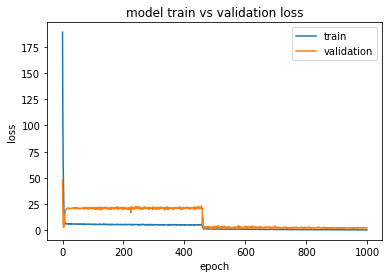

In [28]:
plt.plot(history.history[ 'loss' ]) 
plt.plot(history.history[ 'val_loss' ]) 
plt.title( 'model train vs validation loss' ) 
plt.ylabel( 'loss' ) 
plt.xlabel( 'epoch' ) 
plt.legend([ 'train' , 'validation' ], loc= 'upper right' ) 
plt.show()

In [29]:
y_pred = model.predict(X_test)

In [30]:
y_test = test_df[y_label].values

In [31]:
print(f'MSE = {mean_squared_error(y_test, y_pred)}')
print(f'MAE = {mean_absolute_error(y_test, y_pred)}')
print(f'RMSE = {math.sqrt(mean_squared_error(y_test, y_pred))}')

MSE = 20.582266228538327
MAE = 3.962580678022696
RMSE = 4.536768258191984


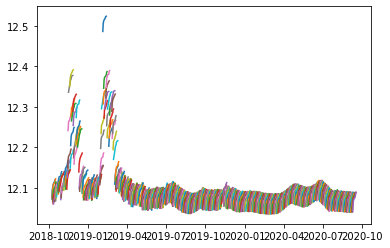

In [32]:
data = df.loc[test_split_idx+1:].Data
for i in range(len(y_pred)-7):
    x = data[i:i+7].tolist()
    y = y_pred[i]
    plt.plot(x, y)